In [1]:
import ray

import torch

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds()


# 数据清洗与可视化

In [2]:
import os
from torch.utils.data import Dataset
from PIL import Image

class PizzaOrNotDataset(Dataset):
    def __init__(self, root_dir: str, transform=None, device="cpu"):
        self.positive_idxs = os.listdir(os.path.join(root_dir, "pizza"))
        self.negative_idxs = os.listdir(os.path.join(root_dir, "not_pizza"))
        self.root_dir = root_dir
        self.transform = transform
        self.device = device

    def __len__(self):
        return self.n_positive + self.n_negative
    
    def __getitem__(self, idx: int):
        if idx < self.n_positive:
            img_name = os.path.join(self.root_dir, "pizza", self.positive_idxs[idx])
            label = 1
        else:
            img_name = os.path.join(self.root_dir, "not_pizza", self.negative_idxs[idx - self.n_positive])
            label = 0

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)
            
        return image.to(self.device), torch.tensor(label).to(self.device)

    @property
    def n_positive(self):
        return len(self.positive_idxs)
    @property
    def n_negative(self):
        return len(self.negative_idxs)

In [3]:
from torchvision.transforms import Compose, ToTensor, Resize

device = "cuda" if torch.cuda.is_available() else "cpu"
pizza_or_not_dataset = PizzaOrNotDataset(
    root_dir="C:/Users/11234/Desktop/MLChem/Github/Mechine-Learning-and-its-Applications-in-Chemistry/Labs/Lab3/pizza_not_pizza",
    transform=Compose([ToTensor(), Resize((128, 128))]),
    device=device
)
X_demo, y_true_demo = pizza_or_not_dataset[0]
X_demo.shape, y_true_demo

(torch.Size([3, 128, 128]), tensor(1, device='cuda:0'))

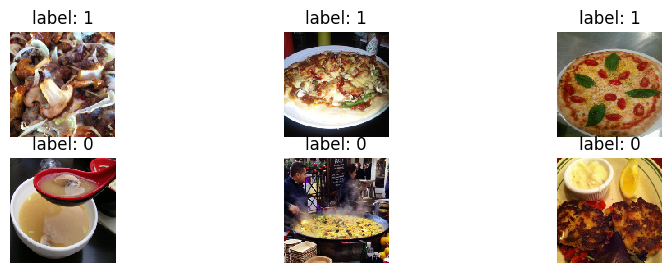

In [4]:
from typing import List
from matplotlib import pyplot as plt

def visualize_data(samples: List, n_rows: int):
    plt.figure(figsize=(10, 3))
    n_samples = len(samples)
    for i, sample in enumerate(samples):
        img, label = sample
        plt.subplot(n_rows, n_samples // n_rows, i + 1)
        plt.imshow(img.permute((1, 2, 0)).cpu(), interpolation="none")
        plt.title(f"label: {int(label.item())}")
        plt.axis("off")
    plt.show()

visualize_data(samples=[pizza_or_not_dataset[i] for i in (300, 600, 900, 1200, 1500, 1800)], n_rows=2)

# 模型的搭建

In [5]:
from torch import nn
from torch.nn import functional as F

class ConvModule(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=kernel_size, dilation=1, padding="same")
        self.pooling1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=kernel_size, dilation=3, padding="same")
        self.pooling2 = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, X):
        X = self.pooling1(F.relu(self.conv1(X)))
        X = self.pooling2(F.relu(self.conv2(X)))
        return X

In [6]:
class PizzaOrNotModel(nn.Module):
    def __init__(self, kernel_size=3, num_hiddens=1024):
        super().__init__()
        self.conv = ConvModule(kernel_size=kernel_size)
        self.fcnn = nn.Linear(16 * 32 * 32, num_hiddens)
        self.fcnn_output = nn.Linear(num_hiddens, 1)
        self.activation = nn.Sigmoid()

    def forward(self, X):
        X = self.conv(X).reshape((X.shape[0], -1))
        X = F.relu(self.fcnn(X))
        X = self.fcnn_output(X)
        return self.activation(X).squeeze()

In [7]:
pizza_or_not_model = PizzaOrNotModel().to(device)
pizza_or_not_model(X_demo.unsqueeze(0))

tensor(0.4869, device='cuda:0', grad_fn=<SqueezeBackward0>)

# 超参数对模型训练的影响: 试验与优化

In [8]:
def train_model_epoch(model, dataloader, optimizer, criterion, log=True):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)
    for i, (X, y_true) in enumerate(dataloader):
        optimizer.zero_grad()
        y_prob = model(X).squeeze()
        loss = criterion(y_prob, y_true.float())
        loss.backward()
        optimizer.step()
        train_loss += loss
        if log:
            if i % 100 == 0:
                print(f"Batch No. {i}, loss = {loss.item()}")
    return (train_loss / num_batches).item()

In [9]:
@torch.no_grad()
def evaluate_model(model, dataloader, criterion, threshold: float=0.5):
    model.eval()
    loss, tp, fp, tn, fn = 0, 0, 0, 0, 0
    num_batches = len(dataloader)
    for X, y_true in dataloader:
        y_prob = model(X).squeeze()
        loss += criterion(y_prob, y_true.float())
        y_pred = (y_prob > threshold)
        for idx in range(y_true.shape[0]):
            true, pred = int(y_true[idx].item()), int(y_pred[idx].item())
            if (true, pred) == (1, 1):
                tp += 1
            elif (true, pred) == (1, 0):
                fn += 1
            elif (true, pred) == (0, 1):
                fp += 1
            else:
                tn += 1
    return (loss / num_batches).item(), tn, fp, fn, tp

## 搭建训练组件

In [10]:
from typing import Dict, List, Tuple
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_model(
    train_subset, val_subset, config: Dict, num_epochs: int=5,
    device="cpu", log=True, save=False
) -> Tuple[List[float], List[float], List[float]]:
    
    model = PizzaOrNotModel(kernel_size=config["kernel_size"], num_hiddens=config["num_hiddens"]).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"], momentum=0.5)

    train_loader = DataLoader(train_subset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=config["batch_size"], shuffle=False)

    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        train_loss = train_model_epoch(model, train_loader, optimizer, criterion, log)
        train_losses.append(train_loss)

        train_loss, tn, fp, fn, tp = evaluate_model(model, train_loader, criterion)
        val_loss, _, _, _, _ = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)

        train_accuracy = (tp + tn) / (tp + tn + fp + fn)
        val_accuracy = (tp + tn) / (tp + tn + fp + fn)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        if log:
             print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if save:
        torch.save(model.state_dict(), "model.pth")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [11]:
torch.cuda.is_available()

True

In [12]:
from torch.utils.data import random_split

config = {
    "kernel_size": 3, "num_hiddens": 1024,
    "batch_size": 8, "lr": 0.01,
}
train_subset, test_subset = random_split(pizza_or_not_dataset, [0.9, 0.1])
train_losses, train_accs, val_losses, val_accs = train_model(train_subset, test_subset, config, log=True, device="cuda" if torch.cuda.is_available() else "cpu")

Batch No. 0, loss = 0.692595362663269
Batch No. 100, loss = 0.630131185054779
Batch No. 200, loss = 0.7157562375068665
Epoch [1/5], Train Loss: 0.6714, Train Accuracy: 0.5802, Val Loss: 0.6836, Val Accuracy: 0.5802
Batch No. 0, loss = 0.6654173135757446
Batch No. 100, loss = 0.796065628528595
Batch No. 200, loss = 0.5149157047271729
Epoch [2/5], Train Loss: 0.6816, Train Accuracy: 0.5503, Val Loss: 0.7235, Val Accuracy: 0.5503
Batch No. 0, loss = 0.5406879186630249
Batch No. 100, loss = 0.5826398134231567
Batch No. 200, loss = 0.5567911267280579
Epoch [3/5], Train Loss: 0.6770, Train Accuracy: 0.6023, Val Loss: 0.6188, Val Accuracy: 0.6023
Batch No. 0, loss = 0.4101336598396301
Batch No. 100, loss = 0.5525227785110474
Batch No. 200, loss = 0.4724721908569336
Epoch [4/5], Train Loss: 0.5746, Train Accuracy: 0.7000, Val Loss: 0.5576, Val Accuracy: 0.7000
Batch No. 0, loss = 0.6644296646118164
Batch No. 100, loss = 0.4603766202926636
Batch No. 200, loss = 0.7491592764854431
Epoch [5/5], T

## 超参数数值的试验

In [13]:
def visualize_learning(
    train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection,
    mode="tune", labels=None
):
    if mode == "tune":
        fig, axes = plt.subplots(2, 2, layout="constrained")
        for label, train_losses in zip(labels, train_losses_collection):
            axes[0][0].plot(train_losses, marker="^", label=label)
        axes[0][0].set_title("Train losses")
        axes[0][0].set_xlabel("Epoch No.")
        axes[0][0].set_ylabel("Loss")
        axes[0][0].legend()
        for label, val_losses in zip(labels, val_losses_collection):
            axes[0][1].plot(val_losses, marker="^", label=label)
        axes[0][1].set_title("Validation losses")
        axes[0][1].set_xlabel("Epoch No.")
        axes[0][1].set_ylabel("Loss")
        axes[0][1].legend()
        for label, train_accs in zip(labels, train_accs_collection):
            axes[1][0].plot(train_accs, marker="^", label=label)
        axes[1][0].set_title("Train accuracies")
        axes[1][0].set_xlabel("Epoch No.")
        axes[1][0].set_ylabel("Accuracy")
        axes[1][0].legend()
        for label, val_accs in zip(labels, val_accs_collection):
            axes[1][1].plot(val_accs, marker="^", label=label)
        axes[1][1].set_title("Validation accuracies")
        axes[1][1].set_xlabel("Epoch No.")
        axes[1][1].set_ylabel("Accuracy")
        axes[1][1].legend()
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot(train_losses_collection, label="train")
        ax1.plot(val_losses_collection, label="test")
        ax1.set_title("Losses on train/test dataset")
        ax1.set_xlabel("Epoch No.")
        ax1.set_ylabel("Loss")
        ax1.legend()
        ax2.plot(train_accs_collection, label="train")
        ax2.plot(val_accs_collection, label="test")
        ax2.set_title("Accuracies on train/test dataset")
        ax2.set_xlabel("Epoch No.")
        ax2.set_ylabel("Accuracy")
        ax2.legend()

Batch No. 0, loss = 0.6935211420059204
Batch No. 100, loss = 0.6571744680404663
Batch No. 200, loss = 0.9982911348342896
Epoch [1/5], Train Loss: 0.6531, Train Accuracy: 0.6486, Val Loss: 0.6601, Val Accuracy: 0.6486
Batch No. 0, loss = 0.6208925247192383
Batch No. 100, loss = 0.6165032386779785
Batch No. 200, loss = 0.6485773324966431
Epoch [2/5], Train Loss: 0.6257, Train Accuracy: 0.6475, Val Loss: 0.6471, Val Accuracy: 0.6475
Batch No. 0, loss = 0.6882889866828918
Batch No. 100, loss = 0.4323400855064392
Batch No. 200, loss = 0.6852492094039917
Epoch [3/5], Train Loss: 0.6452, Train Accuracy: 0.6243, Val Loss: 0.6150, Val Accuracy: 0.6243
Batch No. 0, loss = 0.5289537906646729
Batch No. 100, loss = 0.5836133360862732
Batch No. 200, loss = 0.6671794652938843
Epoch [4/5], Train Loss: 0.5777, Train Accuracy: 0.7102, Val Loss: 0.5817, Val Accuracy: 0.7102
Batch No. 0, loss = 0.5386847257614136
Batch No. 100, loss = 0.5270342826843262
Batch No. 200, loss = 0.41493621468544006
Epoch [5/5

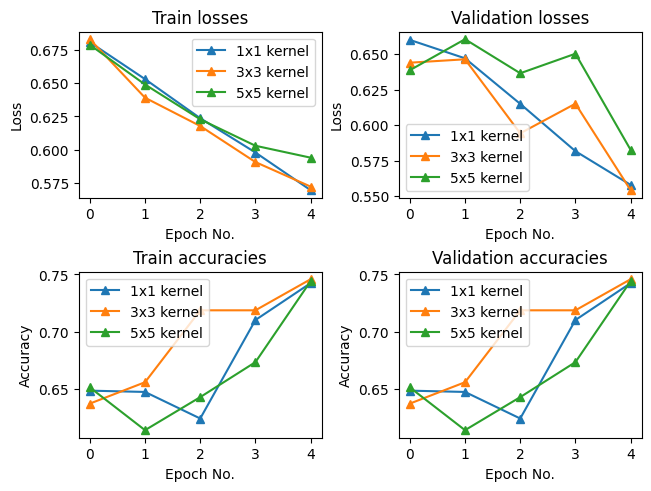

In [14]:
kernel_size_collection = (1, 3, 5)
labels = []
train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection = [], [], [], []

for kernel_size in kernel_size_collection:
    config["kernel_size"] = kernel_size
    labels.append(f"{kernel_size}x{kernel_size} kernel")
    train_losses, train_accs, val_losses, val_accs = train_model(train_subset, test_subset, config, log=True, device=device)
    train_losses_collection.append(train_losses)
    train_accs_collection.append(train_accs)
    val_losses_collection.append(val_losses)
    val_accs_collection.append(val_accs)
    print(f"Kernel size: {kernel_size}x{kernel_size}, {val_losses}")

visualize_learning(
    train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection,
    labels=labels
)

Batch No. 0, loss = 0.6930953860282898
Batch No. 100, loss = 0.6905118227005005
Batch No. 200, loss = 0.6789926886558533
Epoch [1/5], Train Loss: 0.6845, Train Accuracy: 0.5542, Val Loss: 0.6866, Val Accuracy: 0.5542
Batch No. 0, loss = 0.683928370475769
Batch No. 100, loss = 0.678265392780304
Batch No. 200, loss = 0.6680742502212524
Epoch [2/5], Train Loss: 0.6720, Train Accuracy: 0.5966, Val Loss: 0.6764, Val Accuracy: 0.5966
Batch No. 0, loss = 0.6447898149490356
Batch No. 100, loss = 0.7192690968513489
Batch No. 200, loss = 0.656699538230896
Epoch [3/5], Train Loss: 0.6467, Train Accuracy: 0.6847, Val Loss: 0.6466, Val Accuracy: 0.6847
Batch No. 0, loss = 0.6241207122802734
Batch No. 100, loss = 0.6382346153259277
Batch No. 200, loss = 0.7358909845352173
Epoch [4/5], Train Loss: 0.6705, Train Accuracy: 0.5780, Val Loss: 0.7038, Val Accuracy: 0.5780
Batch No. 0, loss = 0.8377052545547485
Batch No. 100, loss = 0.6302534341812134
Batch No. 200, loss = 0.506844699382782
Epoch [5/5], Tr

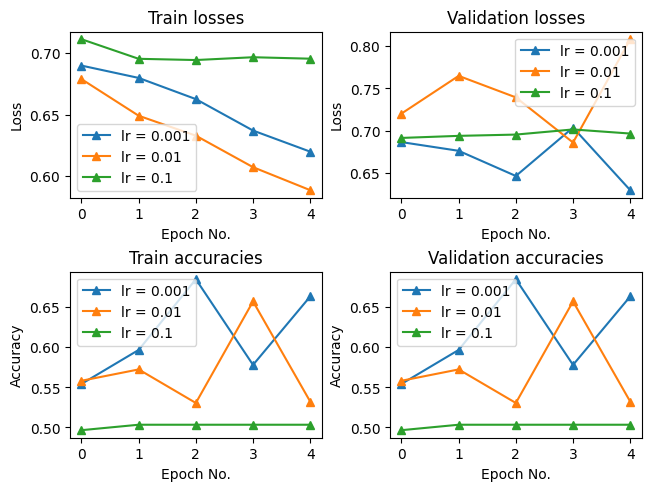

In [15]:
config["batch_size"] = 8
lr_collection = (10 ** n for n in (-3, -2, -1))
labels = []
train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection = [], [], [], []

for lr in lr_collection:
    config["lr"] = lr
    train_losses, train_accs, val_losses, val_accs = train_model(train_subset, test_subset, config, log=True, device=device)
    labels.append(f"lr = {lr}")
    train_losses_collection.append(train_losses)
    train_accs_collection.append(train_accs)
    val_losses_collection.append(val_losses)
    val_accs_collection.append(val_accs)

visualize_learning(
    train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection,
    labels=labels
)

## 超参数的组合优化

In [16]:
from sklearn.model_selection import KFold
from ray import train
import ray.train.torch

n_splits = 5
splits = list(KFold(n_splits=n_splits, shuffle=True, random_state=42).split(train_subset))

def trainable(config):
    ray.train.torch.enable_reproducibility()
    
    total_val_loss, total_val_accuracy = 0, 0
    device = "cuda" if torch.cuda.is_available() else "cpu"

    for train_idx, val_idx in splits:
        train_fold = torch.utils.data.Subset(train_subset, train_idx)
        val_fold = torch.utils.data.Subset(train_subset, val_idx)

        _, _, val_losses, val_accuracies = train_model(
            train_fold, val_fold, config, num_epochs=5, device=device, log=False
        )


        total_val_loss += val_losses[-1]
        total_val_accuracy += val_accuracies[-1]

    avg_val_loss = total_val_loss / n_splits
    avg_val_accuracy = total_val_accuracy / n_splits
    
    ray.train.report({"val_loss": avg_val_loss, "val_acc": avg_val_accuracy})


In [17]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler

scheduler = ASHAScheduler(max_t=10, grace_period=5)

tune_config = tune.TuneConfig(
    metric="val_loss", mode="min",
    scheduler=scheduler,
    num_samples=6,
)

param_space = {
    "lr": tune.loguniform(1e-2, 1e-1),
    "num_hiddens": tune.choice([512, 1024]),
    "kernel_size": tune.choice([3, 5]),
    "batch_size": tune.choice([8, 16, 32])
}

tuner = tune.Tuner(
    trainable=tune.with_resources(
        tune.with_parameters(trainable),
        # resources={"cpu": 2, "gpu": 0}
        resources={"cpu": 15, "gpu": 1}
    ),
    tune_config=tune_config,
    param_space=param_space
)

results = tuner.fit()


2023-11-18 14:29:45,781	INFO tune.py:1144 -- Total run time: 2969.88 seconds (2969.82 seconds for the tuning loop).


In [18]:
best_result = results.get_best_result("val_loss", "min")
best_result.config

{'lr': 0.012165430498723668,
 'num_hiddens': 512,
 'kernel_size': 3,
 'batch_size': 8}

# 模型训练与预测

In [19]:
train_losses, train_accs, test_losses, test_accs = train_model(
    train_subset, test_subset, config=best_result.config, num_epochs=10,
    log=True, save=True, device=device
)

Batch No. 0, loss = 0.6886093616485596
Batch No. 100, loss = 0.6894917488098145
Batch No. 200, loss = 0.8363921642303467
Epoch [1/10], Train Loss: 0.6466, Train Accuracy: 0.6655, Val Loss: 0.6407, Val Accuracy: 0.6655
Batch No. 0, loss = 0.703689455986023
Batch No. 100, loss = 0.6597696542739868
Batch No. 200, loss = 0.47618311643600464
Epoch [2/10], Train Loss: 0.6083, Train Accuracy: 0.6763, Val Loss: 0.6348, Val Accuracy: 0.6763
Batch No. 0, loss = 0.7366918325424194
Batch No. 100, loss = 0.4935041666030884
Batch No. 200, loss = 0.5134974718093872
Epoch [3/10], Train Loss: 0.5625, Train Accuracy: 0.7203, Val Loss: 0.5737, Val Accuracy: 0.7203
Batch No. 0, loss = 0.7004199624061584
Batch No. 100, loss = 0.6055373549461365
Batch No. 200, loss = 1.0333502292633057
Epoch [4/10], Train Loss: 0.5323, Train Accuracy: 0.7599, Val Loss: 0.5565, Val Accuracy: 0.7599
Batch No. 0, loss = 0.5838462114334106
Batch No. 100, loss = 0.6253941655158997
Batch No. 200, loss = 0.895583987236023
Epoch [5

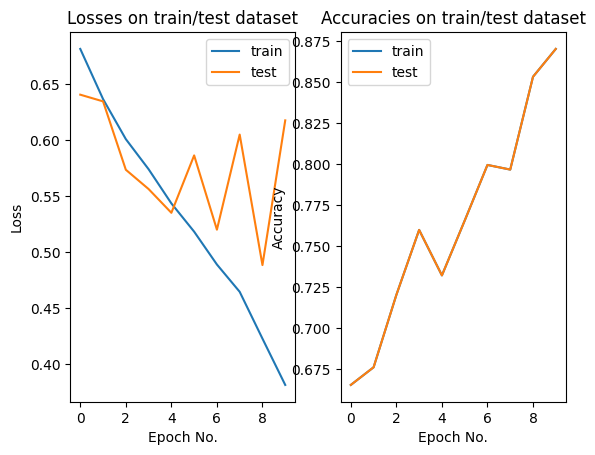

In [20]:
visualize_learning(train_losses, train_accs, test_losses, test_accs, mode="train")

In [21]:
def report_metrics(tn, fp, fn, tp):
    return {
        "accuracy": (tn + tp) / (tn + fp + fn + tp),
        "precision": tp / (tp + fp),
        "recall": tp / (tp + fn)
    }

In [22]:
model = PizzaOrNotModel(
    kernel_size=best_result.config["kernel_size"],
    num_hiddens=best_result.config["num_hiddens"],
).to(device)
model.load_state_dict(torch.load("PizzaOrNotModel.pt"))
_, tn, fp, fn, tp = evaluate_model(model, DataLoader(test_subset), criterion=nn.BCELoss())
report_metrics(tn, fp, fn, tp)

FileNotFoundError: [Errno 2] No such file or directory: 'PizzaOrNotModel.pt'